In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json


# Load the Data

In [2]:
#Import the necessary library 
import pandas as pd 
import numpy as np 
from datetime import datetime
import sys
import ast
import json
import dask.bag as db
import collections

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import defaultdict

import re
import string
import spacy
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# Get a list of dicts and convert into a pandas df.
ai_category_list=['stat.ML','cs.LG','cs.AI','cs.CV'] #Machine Learning,Artificial Intelligence,Computer Vision
records=db.read_text("/kaggle/input/arxiv/*.json").map(lambda x:json.loads(x))
ai_docs = (records.filter(lambda x:any(ele in x['categories'] for ele in ai_category_list)==True))
get_metadata = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'],
                  'abstract':x['abstract'],
                 'version':x['versions'][-1]['created'],
                         'authors_parsed':x['authors_parsed']}

data_main=ai_docs.map(get_metadata).to_dataframe().compute()

data_main.to_excel("AI_ML_ArXiv_Papers.xlsx",index=False,encoding="utf-8")

data_main.head()

,id,title,category,abstract,version,authors_parsed
0,0704.0047,Intelligent location of simultaneously active ...,cs.NE cs.AI,The intelligent acoustic emission locator is...,"Sun, 1 Apr 2007 13:06:50 GMT","[[Kosel, T., ], [Grabec, I., ]]"
1,0704.0050,Intelligent location of simultaneously active ...,cs.NE cs.AI,Part I describes an intelligent acoustic emi...,"Sun, 1 Apr 2007 18:53:13 GMT","[[Kosel, T., ], [Grabec, I., ]]"
2,0704.0304,The World as Evolving Information,cs.IT cs.AI math.IT q-bio.PE,This paper discusses the benefits of describ...,"Wed, 13 Oct 2010 19:49:16 GMT","[[Gershenson, Carlos, ]]"
3,0704.0671,Learning from compressed observations,cs.IT cs.LG math.IT,The problem of statistical learning is to co...,"Thu, 5 Apr 2007 02:57:15 GMT","[[Raginsky, Maxim, ]]"
4,0704.0954,Sensor Networks with Random Links: Topology De...,cs.IT cs.LG math.IT,"In a sensor network, in practice, the commun...","Fri, 6 Apr 2007 21:58:52 GMT","[[Kar, Soummya, ], [Moura, Jose M. F., ]]"


We have successfully load our required dataset of research paper containing only the records regarding human computer interaction from the master json file to pandas dataframe and also save in csv format. 

# Dataset Exploration and Preparation

In [4]:
#Let's see the information ragarding the dataset
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232635 entries, 0 to 232634
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              232635 non-null  object
 1   title           232635 non-null  object
 2   category        232635 non-null  object
 3   abstract        232635 non-null  object
 4   version         232635 non-null  object
 5   authors_parsed  232635 non-null  object
dtypes: object(6)
memory usage: 10.6+ MB


In [5]:
#Extract date time from version 
data_main['updated_date_time']= pd.to_datetime(data_main['version'])
data_main['date']=data_main['updated_date_time'].dt.date
data_main['year']=data_main['updated_date_time'].dt.year
data_main['month']=data_main['updated_date_time'].dt.month
data_main['day_of_week']=data_main['updated_date_time'].dt.day_of_week
data_main.head()

,id,title,category,abstract,version,authors_parsed,updated_date_time,date,year,month,day_of_week
0,0704.0047,Intelligent location of simultaneously active ...,cs.NE cs.AI,The intelligent acoustic emission locator is...,"Sun, 1 Apr 2007 13:06:50 GMT","[[Kosel, T., ], [Grabec, I., ]]",2007-04-01 13:06:50+00:00,2007-04-01,2007,4,6
1,0704.0050,Intelligent location of simultaneously active ...,cs.NE cs.AI,Part I describes an intelligent acoustic emi...,"Sun, 1 Apr 2007 18:53:13 GMT","[[Kosel, T., ], [Grabec, I., ]]",2007-04-01 18:53:13+00:00,2007-04-01,2007,4,6
2,0704.0304,The World as Evolving Information,cs.IT cs.AI math.IT q-bio.PE,This paper discusses the benefits of describ...,"Wed, 13 Oct 2010 19:49:16 GMT","[[Gershenson, Carlos, ]]",2010-10-13 19:49:16+00:00,2010-10-13,2010,10,2
3,0704.0671,Learning from compressed observations,cs.IT cs.LG math.IT,The problem of statistical learning is to co...,"Thu, 5 Apr 2007 02:57:15 GMT","[[Raginsky, Maxim, ]]",2007-04-05 02:57:15+00:00,2007-04-05,2007,4,3
4,0704.0954,Sensor Networks with Random Links: Topology De...,cs.IT cs.LG math.IT,"In a sensor network, in practice, the commun...","Fri, 6 Apr 2007 21:58:52 GMT","[[Kar, Soummya, ], [Moura, Jose M. F., ]]",2007-04-06 21:58:52+00:00,2007-04-06,2007,4,4


In [6]:
#Extract the authors and count of them 
data_main['authors']= data_main['authors_parsed'].apply(lambda authors:[(" ".join(author)).strip() for author in authors])
data_main['authors_count']= data_main['authors_parsed'].apply(lambda x:len(x))
data_main.head()

,id,title,category,abstract,version,authors_parsed,updated_date_time,date,year,month,day_of_week,authors,authors_count
0,0704.0047,Intelligent location of simultaneously active ...,cs.NE cs.AI,The intelligent acoustic emission locator is...,"Sun, 1 Apr 2007 13:06:50 GMT","[[Kosel, T., ], [Grabec, I., ]]",2007-04-01 13:06:50+00:00,2007-04-01,2007,4,6,"[Kosel T., Grabec I.]",2
1,0704.0050,Intelligent location of simultaneously active ...,cs.NE cs.AI,Part I describes an intelligent acoustic emi...,"Sun, 1 Apr 2007 18:53:13 GMT","[[Kosel, T., ], [Grabec, I., ]]",2007-04-01 18:53:13+00:00,2007-04-01,2007,4,6,"[Kosel T., Grabec I.]",2
2,0704.0304,The World as Evolving Information,cs.IT cs.AI math.IT q-bio.PE,This paper discusses the benefits of describ...,"Wed, 13 Oct 2010 19:49:16 GMT","[[Gershenson, Carlos, ]]",2010-10-13 19:49:16+00:00,2010-10-13,2010,10,2,[Gershenson Carlos],1
3,0704.0671,Learning from compressed observations,cs.IT cs.LG math.IT,The problem of statistical learning is to co...,"Thu, 5 Apr 2007 02:57:15 GMT","[[Raginsky, Maxim, ]]",2007-04-05 02:57:15+00:00,2007-04-05,2007,4,3,[Raginsky Maxim],1
4,0704.0954,Sensor Networks with Random Links: Topology De...,cs.IT cs.LG math.IT,"In a sensor network, in practice, the commun...","Fri, 6 Apr 2007 21:58:52 GMT","[[Kar, Soummya, ], [Moura, Jose M. F., ]]",2007-04-06 21:58:52+00:00,2007-04-06,2007,4,4,"[Kar Soummya, Moura Jose M. F.]",2


In [7]:
#User defined function for cleaning the dataset
nlp=spacy.load("en_core_web_sm")

def clean_string(text,stem="None"):
    final_string= ""
    
    #lowercasing the text
    text=text.lower()
    
    #removing the line breaks
    text=re.sub(r'\n',' ',text)
    
    #removing the punctuation
    translator= str.maketrans('','',string.punctuation)
    text= text.translate(translator) 
    
    #removing the stopwords
    text= text.split()
    stop_words= nltk.corpus.stopwords.words("english")
    text_filtered= [word for word in text if not word in stop_words]
    
    #removing the numbers
    text_filtered= [re.sub(r'\w*\d\w*','',w) for w in text_filtered]
    
    #stemming or lemmatizing
    if stem=='Stem':
        stemmer= PorterStemmer()
        text_stemmed= [stemmer.stem(w) for w in text_filtered]
        
    elif stem== 'Lem':
        lem= WordNetLemmatizer()
        text_stemmed= [lem.lemmatize(w) for w in text_filtered]
        
    else:
        text_stemmed= text_filtered
        
    final_string= ' '.join(text_stemmed)
    return final_string

In [8]:
#Cleaning the title and abstract text
data_main['cleaned_title']= data_main['title'].apply(lambda x: clean_string(x,stem='Lem'))
data_main['cleaned_abstract']= data_main['abstract'].apply(lambda x: clean_string(x,stem='Lem'))
data_main.head()

,id,title,category,abstract,version,authors_parsed,updated_date_time,date,year,month,day_of_week,authors,authors_count,cleaned_title,cleaned_abstract
0,0704.0047,Intelligent location of simultaneously active ...,cs.NE cs.AI,The intelligent acoustic emission locator is...,"Sun, 1 Apr 2007 13:06:50 GMT","[[Kosel, T., ], [Grabec, I., ]]",2007-04-01 13:06:50+00:00,2007-04-01,2007,4,6,"[Kosel T., Grabec I.]",2,intelligent location simultaneously active aco...,intelligent acoustic emission locator describe...
1,0704.0050,Intelligent location of simultaneously active ...,cs.NE cs.AI,Part I describes an intelligent acoustic emi...,"Sun, 1 Apr 2007 18:53:13 GMT","[[Kosel, T., ], [Grabec, I., ]]",2007-04-01 18:53:13+00:00,2007-04-01,2007,4,6,"[Kosel T., Grabec I.]",2,intelligent location simultaneously active aco...,part describes intelligent acoustic emission l...
2,0704.0304,The World as Evolving Information,cs.IT cs.AI math.IT q-bio.PE,This paper discusses the benefits of describ...,"Wed, 13 Oct 2010 19:49:16 GMT","[[Gershenson, Carlos, ]]",2010-10-13 19:49:16+00:00,2010-10-13,2010,10,2,[Gershenson Carlos],1,world evolving information,paper discus benefit describing world informat...
3,0704.0671,Learning from compressed observations,cs.IT cs.LG math.IT,The problem of statistical learning is to co...,"Thu, 5 Apr 2007 02:57:15 GMT","[[Raginsky, Maxim, ]]",2007-04-05 02:57:15+00:00,2007-04-05,2007,4,3,[Raginsky Maxim],1,learning compressed observation,problem statistical learning construct predict...
4,0704.0954,Sensor Networks with Random Links: Topology De...,cs.IT cs.LG math.IT,"In a sensor network, in practice, the commun...","Fri, 6 Apr 2007 21:58:52 GMT","[[Kar, Soummya, ], [Moura, Jose M. F., ]]",2007-04-06 21:58:52+00:00,2007-04-06,2007,4,4,"[Kar Soummya, Moura Jose M. F.]",2,sensor network random link topology design dis...,sensor network practice communication among se...


In [9]:
#Extracting only the required column for further analysis
df= data_main[['id','cleaned_title','cleaned_abstract','date','year','month','day_of_week','authors','authors_count']].copy()
df.head()

,id,cleaned_title,cleaned_abstract,date,year,month,day_of_week,authors,authors_count
0,0704.0047,intelligent location simultaneously active aco...,intelligent acoustic emission locator describe...,2007-04-01,2007,4,6,"[Kosel T., Grabec I.]",2
1,0704.0050,intelligent location simultaneously active aco...,part describes intelligent acoustic emission l...,2007-04-01,2007,4,6,"[Kosel T., Grabec I.]",2
2,0704.0304,world evolving information,paper discus benefit describing world informat...,2010-10-13,2010,10,2,[Gershenson Carlos],1
3,0704.0671,learning compressed observation,problem statistical learning construct predict...,2007-04-05,2007,4,3,[Raginsky Maxim],1
4,0704.0954,sensor network random link topology design dis...,sensor network practice communication among se...,2007-04-06,2007,4,4,"[Kar Soummya, Moura Jose M. F.]",2


Our dataset comprised of only AI records is processed and cleaned to explore further

# General Exploratory Analysis

Text(0, 0.5, 'Count of total papers')

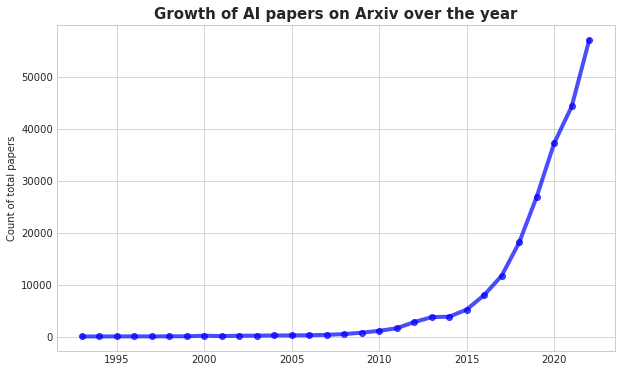

In [10]:
#Let's see the growth of publication 
papers_over_year=df.groupby(['year']).size().reset_index().rename(columns={0:'total_papers'})

#We will loss the data for 2023 as the year is still counting 
papers_over_year=papers_over_year[papers_over_year['year']!=2023]    

#Initialize the plot
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(papers_over_year['year'],papers_over_year['total_papers'],marker='o',color='blue',linewidth=4, alpha=0.7)

#Labelling the plot
plt.title("Growth of AI papers on Arxiv over the year",fontsize=15, fontweight='semibold')
plt.ylabel("Count of total papers",fontsize=10)

we can see the count of total published papers related to AI, ML, CV has exponentially increased since 2010. 

## Exploratory Analysis of Title

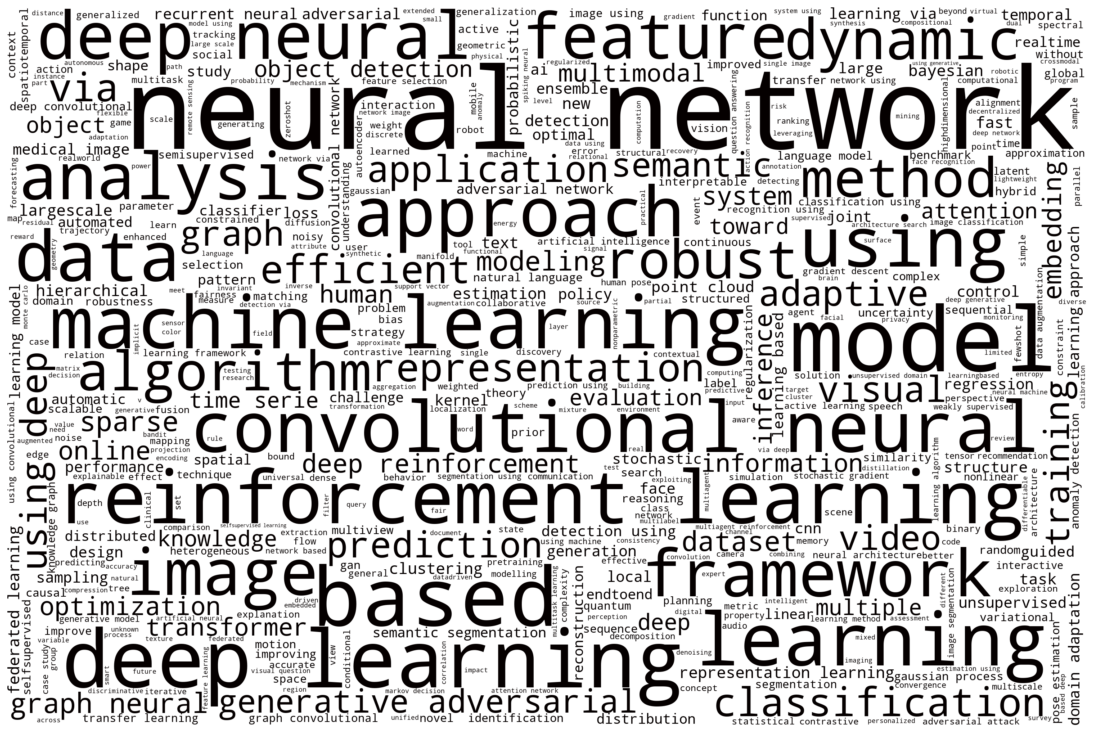

In [11]:
wordcloud= WordCloud(background_color='white', width=3000, height=2000, max_words=500).generate(''.join(df['cleaned_title']))

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

wordcloud.recolor(color_func=black_color_func)

plt.figure(figsize=[15,10])
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

In [12]:
#Create a user define function to create N-Gram

def generate_ngrams(text,n_gram=1):
    token= [token for token in text.lower().split(' ')]
    ngrams= zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

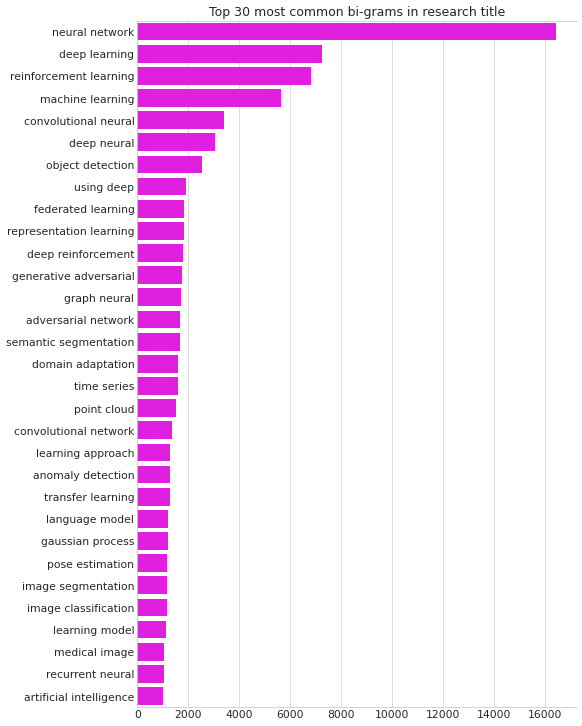

In [13]:
#Create bi-gram of the title [we will only take top 20 bi-gram]
title_ngram= defaultdict(int)
for title in df['cleaned_title']:
    for word in generate_ngrams(title,2):
        title_ngram[word] +=1
        
title_bigram_df= pd.DataFrame(sorted(title_ngram.items(), key= lambda x: x[1])[::-1])

bigram_top30=title_bigram_df[:31]

#Plotting the bi-gram
fig, axes = plt.subplots(ncols=1, figsize=(8, 12), dpi=60)
plt.tight_layout()

sns.barplot(y=bigram_top30[0], x=bigram_top30[1], ax=axes, color='magenta')

axes.spines['right'].set_visible(False)
axes.set_xlabel('')
axes.set_ylabel('')
axes.tick_params(axis='x', labelsize=13)
axes.tick_params(axis='y', labelsize=13)

axes.set_title(f'Top 30 most common bi-grams in research title', fontsize=15)

plt.show()

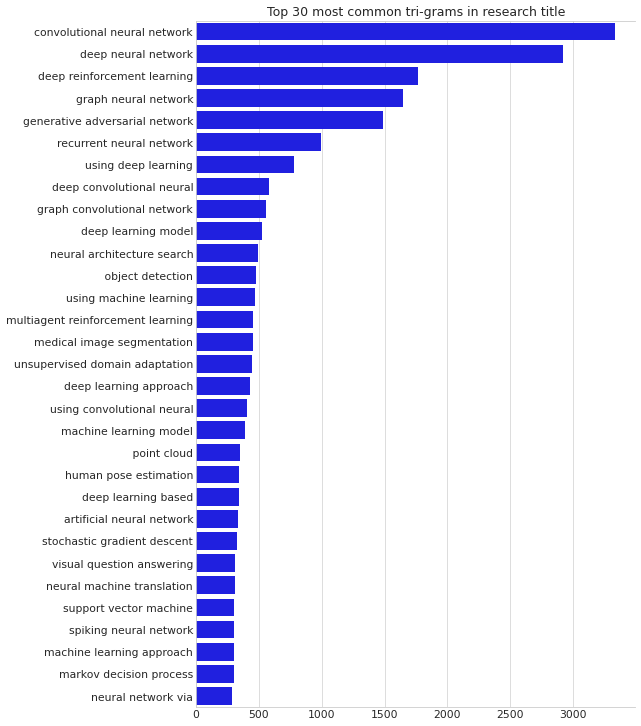

In [14]:
#Create tri-gram of the title [we will only take top 20 tri-gram]
title_ngram= defaultdict(int)
for title in df['cleaned_title']:
    for word in generate_ngrams(title,3):
        title_ngram[word] +=1
        
title_trigram_df= pd.DataFrame(sorted(title_ngram.items(), key= lambda x: x[1])[::-1])

trigram_top30=title_trigram_df[:31]

#Plotting the tri-gram
fig, axes = plt.subplots(ncols=1, figsize=(8, 12), dpi=60)
plt.tight_layout()

sns.barplot(y=trigram_top30[0], x=trigram_top30[1], ax=axes, color='blue')

axes.spines['right'].set_visible(False)
axes.set_xlabel('')
axes.set_ylabel('')
axes.tick_params(axis='x', labelsize=13)
axes.tick_params(axis='y', labelsize=13)

axes.set_title(f'Top 30 most common tri-grams in research title', fontsize=15)

plt.show()